In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
# Function to load data
def load_student_data():
    # Load datasets
    math_data = pd.read_csv('/kaggle/input/student-2/student-mat.csv', sep=';')
    portuguese_data = pd.read_csv('/kaggle/input/student-2/student-por.csv', sep=';')

    # Merge datasets on common attributes
    common_columns = list(set(math_data.columns) & set(portuguese_data.columns))
    combined_data = pd.merge(math_data, portuguese_data, on=common_columns, suffixes=('_math', '_por'))

    print(f"Loaded {math_data.shape[0]} math students, {portuguese_data.shape[0]} Portuguese students.")
    print(f"After merging, we have {combined_data.shape[0]} students who took both courses.")

    return math_data, portuguese_data, combined_data



In [ ]:
# Load the datasets
math_df, portuguese_df, merged_df = load_student_data()

# Display first few rows of the math dataset
math_df.head()

Loaded 395 math students, 649 Portuguese students.
After merging, we have 0 students who took both courses.


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [ ]:
# Data preprocessing function
def preprocess_dataset(dataframe, subject='math'):
    # Create a copy of the dataframe to avoid modifying the original
    df = dataframe.copy()

    # Define categorical and numerical columns
    categorical_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
                            'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
                            'nursery', 'higher', 'internet', 'romantic']

    numerical_features = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                          'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

    # Select target column based on the subject
    if subject == 'math':
        grade_columns = ['G1', 'G2', 'G3']
    else:  # Portuguese
        if '_por' in dataframe.columns[0]:  # Check if using the merged dataset
            grade_columns = ['G1_por', 'G2_por', 'G3_por']
        else:
            grade_columns = ['G1', 'G2', 'G3']

    # Create target variable (performance tier based on final grade G3)
    final_grade_column = grade_columns[-1]
    df['performance_tier'] = pd.cut(df[final_grade_column],
                                    bins=[-1, 10, 15, 20],
                                    labels=['low', 'average', 'high'])

    # Drop grade columns to prevent data leakage
    df = df.drop(columns=grade_columns)

    # Split features and target
    X = df.drop(columns=['performance_tier'])
    y = df['performance_tier']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Create preprocessing pipelines for categorical and numerical features
    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    numerical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_pipeline, categorical_features),
            ('num', numerical_pipeline, numerical_features)
        ])

    return X_train, X_test, y_train, y_test, preprocessor, categorical_features, numerical_features

In [ ]:
# Preprocess the math dataset
print("\n--- Data Preprocessing ---")
X_train, X_test, y_train, y_test, preprocessor, cat_cols, num_cols = preprocess_dataset(math_df)

# Display first few rows of the training data
X_train.head()


--- Data Preprocessing ---


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
181,GP,M,16,U,GT3,T,3,3,services,other,...,yes,yes,yes,4,2,3,1,2,3,2
30,GP,M,15,U,GT3,T,4,4,health,services,...,yes,yes,no,5,4,2,3,4,5,0
292,GP,F,18,U,LE3,T,2,1,services,at_home,...,yes,yes,yes,5,4,3,1,1,5,12
384,MS,M,18,R,GT3,T,4,2,other,other,...,yes,no,no,5,4,3,4,3,3,14
35,GP,F,15,U,GT3,T,2,3,other,other,...,yes,no,no,3,5,1,1,1,5,0


In [ ]:
y_train.head()

181    average
30     average
292    average
384        low
35         low
Name: performance_tier, dtype: category
Categories (3, object): ['low' < 'average' < 'high']

In [ ]:
# Exploratory Data Analysis (EDA) function
def perform_eda(dataframe, target_column='performance_tier'):
    # Basic information about the dataset
    print(f"Dataset shape: {dataframe.shape}")
    print("\nFeature information:")
    print(dataframe.info())
    print("\nDescriptive statistics:")
    print(dataframe.describe())

    # Check for missing values
    missing_values = dataframe.isnull().sum()
    if missing_values.sum() > 0:
        print("\nMissing values per column:")
        print(missing_values[missing_values > 0])
    else:
        print("\nNo missing values found!")

    # Target variable distribution
    if target_column in dataframe.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=dataframe, x=target_column)
        plt.title(f'Distribution of {target_column}')
        plt.xticks(rotation=45)
        plt.show()

        print(f"\nTarget variable distribution:")
        print(dataframe[target_column].value_counts(normalize=True))

    # Correlation analysis for numerical features
    numerical_columns = dataframe.select_dtypes(include=['int64', 'float64']).columns
    if len(numerical_columns) > 0:
        plt.figure(figsize=(14, 10))
        correlation = dataframe[numerical_columns].corr()
        sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
        plt.title('Correlation Heatmap of Numerical Features')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # Feature distributions by target class
    if target_column in dataframe.columns and len(numerical_columns) > 0:
        key_features = ['studytime', 'failures', 'absences', 'age']

        for feature in key_features:
            if feature in dataframe.columns:
                plt.figure(figsize=(10, 6))
                sns.boxplot(data=dataframe, x=target_column, y=feature)
                plt.title(f'{feature} Distribution by {target_column}')
                plt.xticks(rotation=45)
                plt.show()



--- Exploratory Data Analysis ---
Dataset shape: (395, 33)

Feature information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activiti

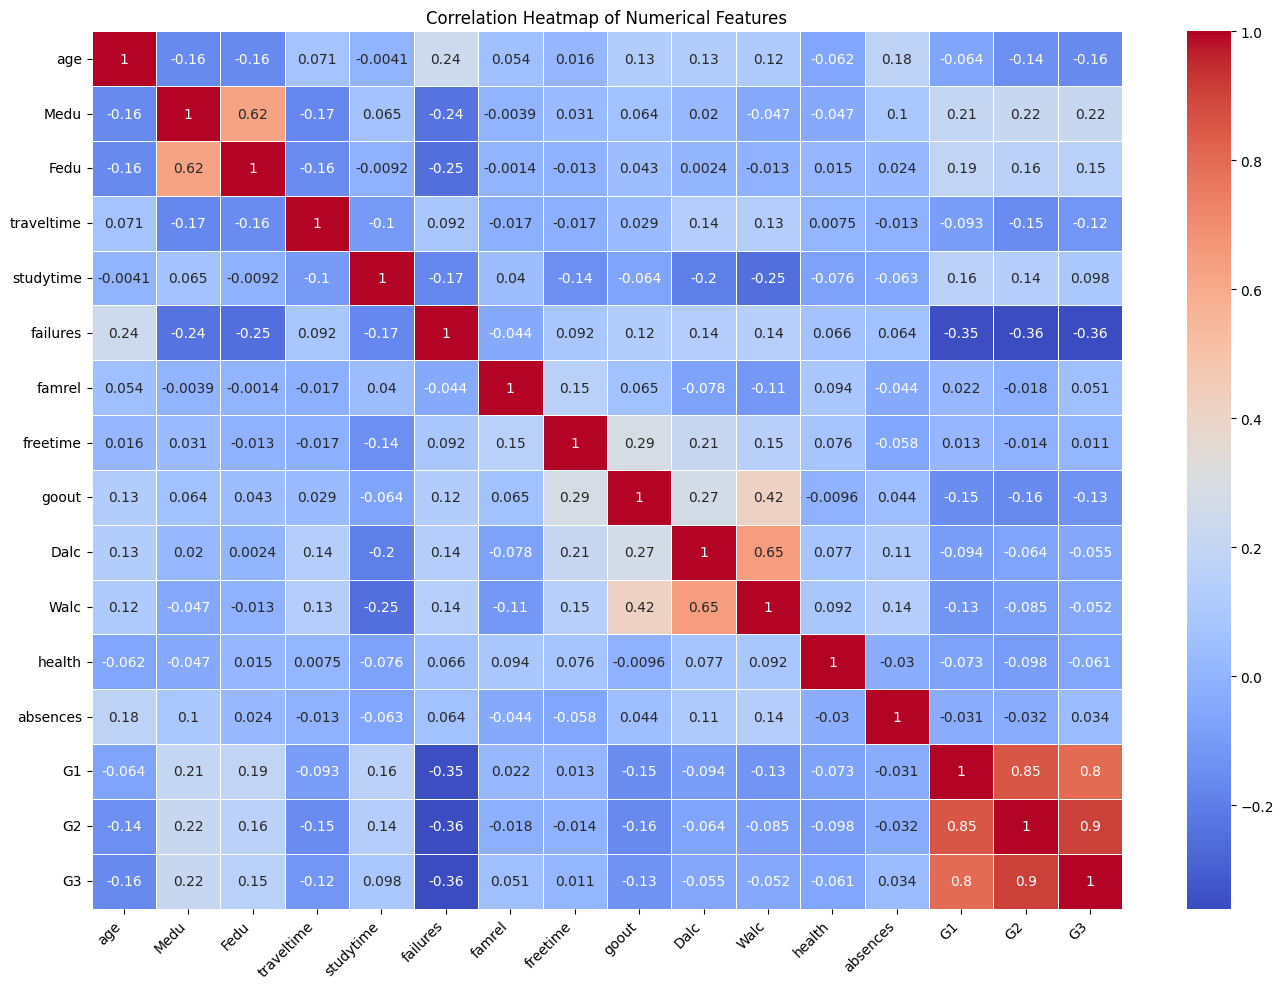

In [ ]:
# Perform EDA on the math dataset
print("\n--- Exploratory Data Analysis ---")
perform_eda(math_df)

In [ ]:
# Function to train models
def train_models(X_train, y_train, preprocessor):
    # Baseline model (predict majority class)
    baseline_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DummyClassifier(strategy='most_frequent'))
    ])

    # Decision Tree model
    decision_tree_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ])

    # Random Forest model
    random_forest_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])

    # SVM model
    svm_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(probability=True, random_state=42))
    ])

    # Neural Network (MLP) model
    neural_network_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', MLPClassifier(random_state=42, max_iter=1000))
    ])

    # Dictionary of models
    models = {
        'Baseline': baseline_model,
        'Decision Tree': decision_tree_model,
        'Random Forest': random_forest_model,
        'SVM': svm_model,
        'Neural Network': neural_network_model
    }

    # Train all models
    trained_models = {}
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        trained_models[name] = model

    return trained_models

In [ ]:
# Train initial models
print("\n--- Training Initial Models ---")
trained_models = train_models(X_train, y_train, preprocessor)


--- Training Initial Models ---
Training Baseline...
Training Decision Tree...
Training Random Forest...
Training SVM...
Training Neural Network...


In [ ]:
# Model evaluation function
def evaluate_models(models, X_test, y_test, baseline=None):
    results = {}

    # Evaluate each model
    for name, model in models.items():
        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store results
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

        # Print results
        print(f"\nResults for {name}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Print detailed classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

    # Compare models to baseline if provided
    if baseline:
        baseline_y_pred = baseline.predict(X_test)
        baseline_accuracy = accuracy_score(y_test, baseline_y_pred)

        # Calculate improvement over baseline
        for name, metrics in results.items():
            if name != 'Baseline':
                improvement = (metrics['accuracy'] - baseline_accuracy) / baseline_accuracy * 100
                print(f"\n{name} improves over baseline by {improvement:.2f}%")

    # Summarize all models
    summary = pd.DataFrame(results).T
    print("\nModel Performance Summary:")
    print(summary)

    # Visualize model comparison
    plt.figure(figsize=(12, 8))
    summary.plot(kind='bar', figsize=(12, 8))
    plt.title('Model Performance Comparison')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    return results, summary




--- Evaluating Initial Models ---

Results for Baseline:
Accuracy: 0.4684
Precision: 0.2194
Recall: 0.4684
F1 Score: 0.2988

Classification Report:
              precision    recall  f1-score   support

     average       0.00      0.00      0.00        34
        high       0.00      0.00      0.00         8
         low       0.47      1.00      0.64        37

    accuracy                           0.47        79
   macro avg       0.16      0.33      0.21        79
weighted avg       0.22      0.47      0.30        79


Results for Decision Tree:
Accuracy: 0.4937
Precision: 0.4951
Recall: 0.4937
F1 Score: 0.4890

Classification Report:
              precision    recall  f1-score   support

     average       0.50      0.62      0.55        34
        high       0.14      0.12      0.13         8
         low       0.57      0.46      0.51        37

    accuracy                           0.49        79
   macro avg       0.40      0.40      0.40        79
weighted avg       0.50  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

<Figure size 1200x800 with 0 Axes>

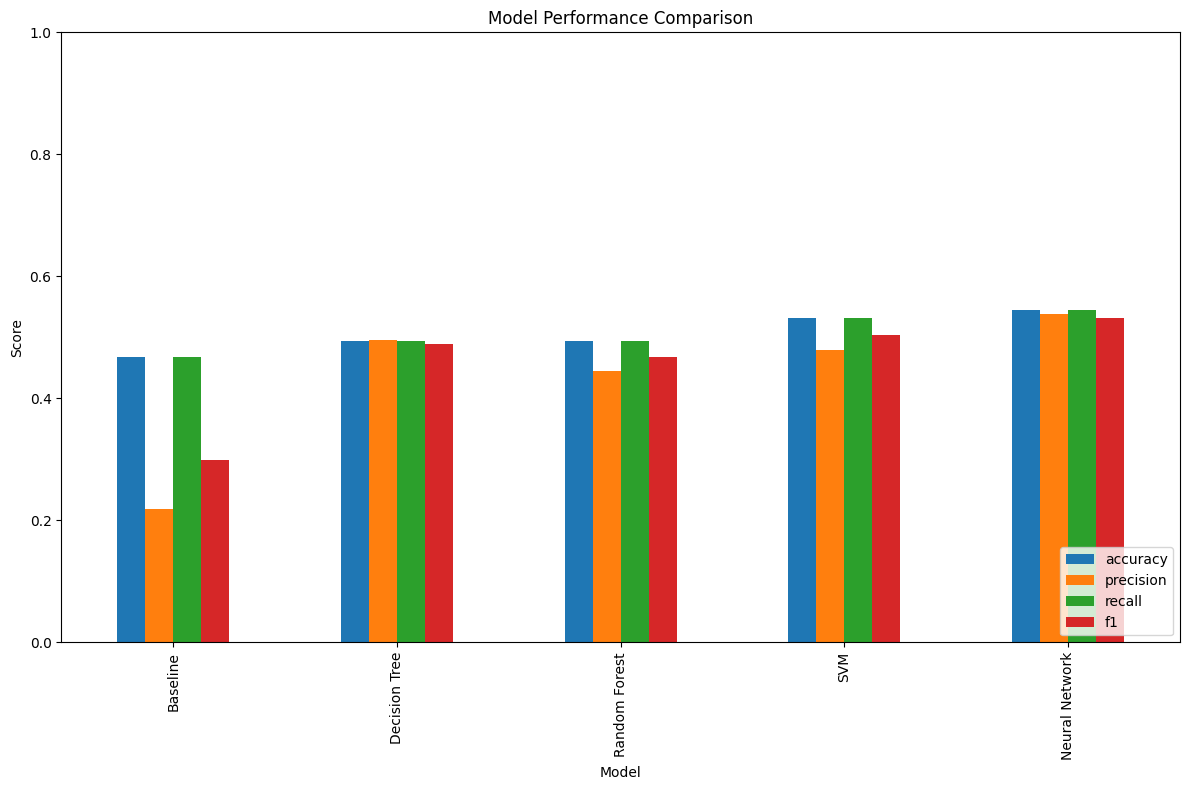

In [ ]:
# Evaluate initial models
print("\n--- Evaluating Initial Models ---")
baseline_model = trained_models['Baseline']
initial_results, initial_summary = evaluate_models(trained_models, X_test, y_test, baseline_model)


In [ ]:
# Hyperparameter tuning function
def tune_hyperparameters(X_train, y_train, preprocessor):
    # Define parameter grids for each model
    decision_tree_params = {
        'classifier__max_depth': [None, 5, 10, 15],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }

    random_forest_params = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    }

    svm_params = {
        'classifier__C': [0.1, 1, 10],
        'classifier__gamma': ['scale', 'auto', 0.1, 0.01],
        'classifier__kernel': ['rbf', 'poly', 'sigmoid']
    }

    neural_network_params = {
        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'classifier__activation': ['relu', 'tanh'],
        'classifier__alpha': [0.0001, 0.001, 0.01]
    }

    # Define models with their parameter grids
    models_to_tune = {
        'Decision Tree': (
            Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', DecisionTreeClassifier(random_state=42))
            ]),
            decision_tree_params
        ),
        'Random Forest': (
            Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', RandomForestClassifier(random_state=42))
            ]),
            random_forest_params
        ),
        'SVM': (
            Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', SVC(probability=True, random_state=42))
            ]),
            svm_params
        ),
        'Neural Network': (
            Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', MLPClassifier(random_state=42, max_iter=1000))
            ]),
            neural_network_params
        )
    }

    # Perform grid search for each model
    best_models = {}
    for name, (model, params) in models_to_tune.items():
        print(f"Tuning {name}...")
        grid_search = GridSearchCV(model, params, cv=5, scoring='f1_weighted', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        print(f"Best parameters for {name}: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

        best_models[name] = grid_search.best_estimator_

    return best_models





In [ ]:
# Perform hyperparameter tuning
print("\n--- Hyperparameter Tuning ---")
best_models = tune_hyperparameters(X_train, y_train, preprocessor)


--- Hyperparameter Tuning ---
Tuning Decision Tree...
Best parameters for Decision Tree: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}
Best cross-validation score: 0.5129
Tuning Random Forest...
Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best cross-validation score: 0.5816
Tuning SVM...
Best parameters for SVM: {'classifier__C': 10, 'classifier__gamma': 'auto', 'classifier__kernel': 'sigmoid'}
Best cross-validation score: 0.5869
Tuning Neural Network...
Best parameters for Neural Network: {'classifier__activation': 'tanh', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (100,)}
Best cross-validation score: 0.5736



--- Evaluating Tuned Models ---

Results for Decision Tree:
Accuracy: 0.4810
Precision: 0.4806
Recall: 0.4810
F1 Score: 0.4755

Classification Report:
              precision    recall  f1-score   support

     average       0.50      0.62      0.55        34
        high       0.00      0.00      0.00         8
         low       0.57      0.46      0.51        37

    accuracy                           0.48        79
   macro avg       0.36      0.36      0.35        79
weighted avg       0.48      0.48      0.48        79


Results for Random Forest:
Accuracy: 0.4937
Precision: 0.4445
Recall: 0.4937
F1 Score: 0.4677

Classification Report:
              precision    recall  f1-score   support

     average       0.46      0.53      0.49        34
        high       0.00      0.00      0.00         8
         low       0.53      0.57      0.55        37

    accuracy                           0.49        79
   macro avg       0.33      0.37      0.35        79
weighted avg       0.4

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

<Figure size 1200x800 with 0 Axes>

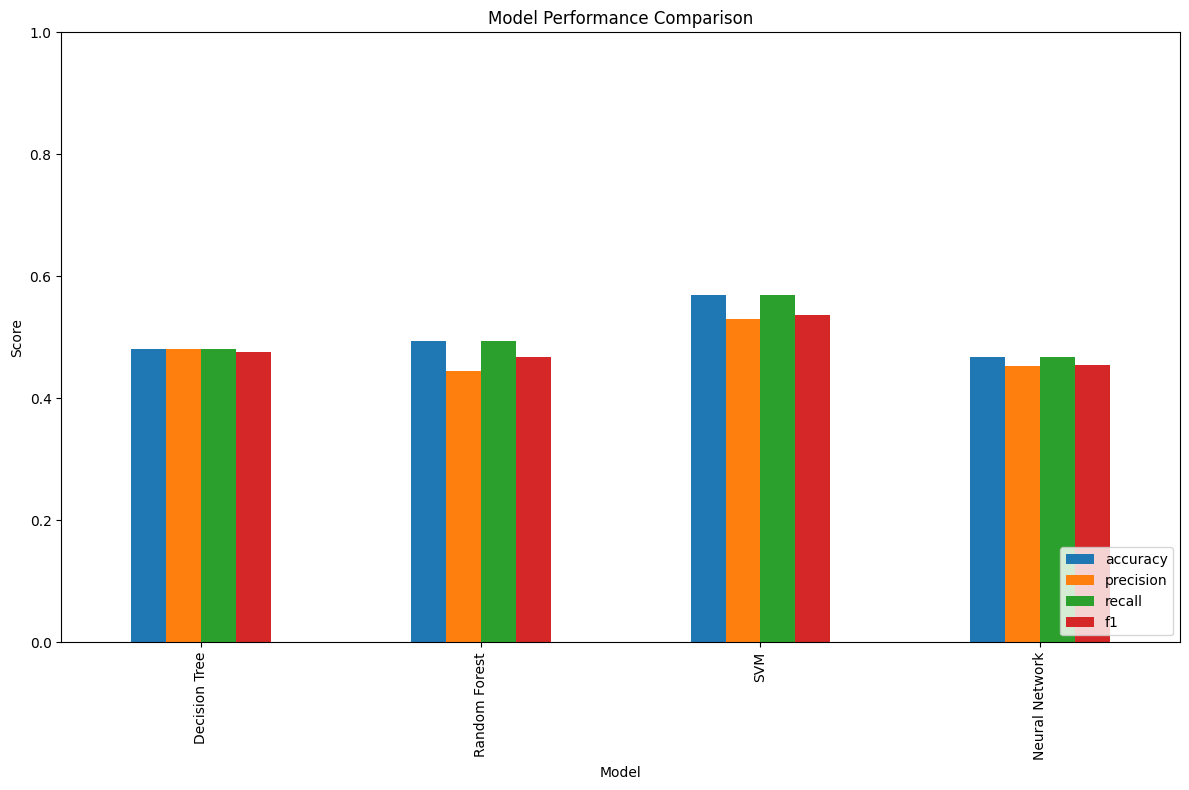

In [ ]:
# Evaluate tuned models
print("\n--- Evaluating Tuned Models ---")
tuned_results, tuned_summary = evaluate_models(best_models, X_test, y_test, baseline_model)


In [ ]:
# Feature engineering function
def perform_feature_engineering(X_train, y_train, X_test, trained_model, preprocessor, n_features=10):
    # Apply the preprocessor to get the transformed features
    X_train_processed = preprocessor.fit_transform(X_train)

    # Recursive Feature Elimination (RFE)
    print("Performing Recursive Feature Elimination...")

    # Handle SVM models differently
    if isinstance(trained_model.named_steps['classifier'], SVC):
        print("SVM model detected. Using a linear SVC for feature selection instead...")
        from sklearn.svm import LinearSVC
        feature_selector = LinearSVC(C=1, penalty="l1", dual=False, random_state=42)
        feature_selector.fit(X_train_processed, y_train)

        # Get absolute values of coefficients for feature ranking
        importance = np.abs(feature_selector.coef_).sum(axis=0)
        indices = np.argsort(importance)[::-1][:n_features]

        # Create dummy ranking (lower is better)
        ranking = np.zeros(X_train_processed.shape[1], dtype=int)
        ranking[indices] = range(1, len(indices) + 1)
        ranking[~np.isin(np.arange(ranking.shape[0]), indices)] = len(indices) + 1

        # Create a feature_ranking DataFrame similar to RFE output
        feature_ranking = pd.DataFrame({
            'Feature': preprocessor.get_feature_names_out(),
            'Importance': np.zeros(X_train_processed.shape[1]),
            'Ranking': ranking
        })

        # Fill in importance values
        feature_ranking.loc[feature_ranking.index[indices], 'Importance'] = importance[indices]
        feature_ranking = feature_ranking.sort_values('Ranking')

    else:
        # Use standard RFE process
        rfe = RFE(estimator=trained_model.named_steps['classifier'], n_features_to_select=n_features)
        rfe.fit(X_train_processed, y_train)

        # Get feature importance or ranking
        feature_ranking = pd.DataFrame({
            'Feature': preprocessor.get_feature_names_out(),
            'Ranking': rfe.ranking_
        })
        feature_ranking = feature_ranking.sort_values('Ranking')

    print("Top features from feature selection:")
    print(feature_ranking.head(n_features))

    # Principal Component Analysis (PCA)
    print("\nPerforming PCA...")
    pca = PCA(n_components=0.95)  # Keep 95% of variance
    X_train_pca = pca.fit_transform(X_train_processed)
    X_test_processed = preprocessor.transform(X_test)
    X_test_pca = pca.transform(X_test_processed)

    print(f"Original number of features: {X_train_processed.shape[1]}")
    print(f"Number of features after PCA: {X_train_pca.shape[1]}")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

    return X_train_pca, X_test_pca, feature_ranking, pca


In [ ]:

# Perform feature engineering with the best model
print("\n--- Feature Engineering ---")
best_model_name = tuned_summary['f1'].idxmax()
print(f"Using {best_model_name} for feature engineering")
X_train_pca, X_test_pca, feature_ranking, pca = perform_feature_engineering(
    X_train, y_train, X_test, best_models[best_model_name], preprocessor)


--- Feature Engineering ---
Using SVM for feature engineering
Performing Recursive Feature Elimination...
SVM model detected. Using a linear SVC for feature selection instead...
Top features from feature selection:
                Feature  Importance  Ranking
28   cat__schoolsup_yes    1.674971        1
37       cat__higher_no    1.271635        2
48        num__failures    1.166433        3
19    cat__Fjob_teacher    1.024715        4
10    cat__Mjob_at_home    0.762116        5
1        cat__school_MS    0.742972        6
14    cat__Mjob_teacher    0.649184        7
26  cat__guardian_other    0.559641        8
35      cat__nursery_no    0.535957        9
15    cat__Fjob_at_home    0.533477       10

Performing PCA...
Original number of features: 56
Number of features after PCA: 28
Explained variance ratio: [0.12333246 0.104111   0.06739888 0.06095025 0.05373271 0.05085993
 0.04670415 0.04426955 0.0388922  0.03743842 0.033893   0.02959013
 0.02640195 0.02424078 0.0229898  0.02074982 